<a href="https://colab.research.google.com/github/octavnicul3scu/product_category_classifier/blob/main/eda_cleaning_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Importam bibliotecile de baza pentru lucru cu date tabulare (pandas),
# calcule numerice (numpy) si expresii regulate (re - util la curatare text daca e nevoie).
import pandas as pd
import numpy as np
import re

# Setari de afisare in notebook ca sa vedem mai bine continutul:
# - max_colwidth: sa nu ne taie titlurile prea repede
# - max_columns: sa vedem mai multe coloane in tabel
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", 50)


In [19]:
# In Colab: Files (stanga) -> Upload -> selectezi fisierul CSV
# Apoi setam calea catre fisierul incarcat in /content
CSV_PATH = "/content/products.csv"

# Citim CSV-ul intr-un DataFrame
df = pd.read_csv(CSV_PATH)

# Verificam dimensiunea dataset-ului (randuri, coloane) si primele 3 randuri
df.shape, df.head(3)


((35311, 8),
    product ID  \
 0           1   
 1           2   
 2           3   
 
                                                             Product Title  \
 0                                         apple iphone 8 plus 64gb silver   
 1                                     apple iphone 8 plus 64 gb spacegrau   
 2  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold   
 
    Merchant ID  Category Label _Product Code  Number_of_Views  \
 0            1   Mobile Phones    QA-2276-XC            860.0   
 1            2   Mobile Phones    KA-2501-QO           3772.0   
 2            3   Mobile Phones    FP-8086-IE           3092.0   
 
    Merchant Rating  Listing Date    
 0              2.5       5/10/2024  
 1              4.8      12/31/2024  
 2              3.9      11/10/2024  )

In [20]:
# Uneori coloanele pot avea spatii inainte/dupa nume, ceea ce strica accesul la ele.
# De exemplu "Product Title " vs "Product Title".
# De aceea facem strip() pe numele coloanelor.
df.columns = [c.strip() for c in df.columns]

# Afisam lista de coloane ca sa stim exact cum se numesc
df.columns


Index(['product ID', 'Product Title', 'Merchant ID', 'Category Label',
       '_Product Code', 'Number_of_Views', 'Merchant Rating', 'Listing Date'],
      dtype='object')

In [21]:
# df.info() ne spune:
# - tipurile de date pe coloane (int/float/string)
# - cate valori non-null avem
# E util ca sa vedem rapid daca avem lipsuri sau tipuri gresite.
display(df.info())

# Calculam procentul de valori lipsa pe fiecare coloana.
# isna().mean() -> proportie de NA (0.0 - 1.0)
missing = df.isna().mean().sort_values(ascending=False)
missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3   Category Label   35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7   Listing Date     35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB


None

,0
Product Title,0.004871
Merchant Rating,0.004814
_Product Code,0.002690
Listing Date,0.001671
Category Label,0.001246
Number_of_Views,0.000396
Merchant ID,0.000000
product ID,0.000000


In [22]:
# Vrem sa vedem cate produse avem in fiecare categorie (Category Label).
# Acest pas e important ca sa detectam:
# - dezechilibru (unele clase foarte mari, altele mici)
# - etichete "murdare" (scrise diferit, de ex "fridge" vs "Fridges")
df["Category Label"].value_counts(dropna=False).head(30)


,count
Category Label,
Fridge Freezers,5495
Washing Machines,4036
Mobile Phones,4020
CPUs,3771
TVs,3564
Fridges,3457
Dishwashers,3418
Digital Cameras,2696
Microwaves,2338


In [23]:
# Aici facem curatarea minima, ca sa avem date consistente pentru ML.

# 1) Standardizam cateva etichete care apar in forma diferita.
#    Exemplu: "Mobile Phone" vs "Mobile Phones"
LABEL_FIX = {
    "fridge": "Fridges",
    "CPU": "CPUs",
    "Mobile Phone": "Mobile Phones",
}

# Lucram pe o copie ca sa pastram df original intact (bun pentru comparatii in notebook)
df2 = df.copy()

# 2) Curatam titlul produsului (feature-ul nostru principal):
# - transformam in string
# - inlocuim lipsurile cu ""
# - strip() ca sa eliminam spatiile de la inceput/sfarsit
# - lower() ca sa avem text uniform (aceleasi cuvinte, aceleasi litere)
df2["Product Title"] = (
    df2["Product Title"]
      .astype("string")
      .fillna("")
      .str.strip()
      .str.lower()
)

# 3) Eliminam randurile unde titlul e gol dupa curatare.
#    Nu are sens sa antrenam pe titluri goale.
df2 = df2[df2["Product Title"].str.len() > 0].copy()

# 4) Curatam label-ul (target-ul):
# - strip() ca sa eliminam spatii
# - inlocuim etichetele problematice cu varianta standard
df2["Category Label"] = df2["Category Label"].astype("string").str.strip()
df2["Category Label"] = df2["Category Label"].replace(LABEL_FIX)

# 5) Eliminam randurile fara categorie (nu le putem folosi la training)
df2 = df2[df2["Category Label"].notna()].copy()

# Afisam noua dimensiune dupa curatare
df2.shape


(35096, 8)

In [24]:
# Verificam din nou distributia pe categorii.
# Dupa LABEL_FIX, ar trebui sa vedem etichete mai consistente.
df2["Category Label"].value_counts().head(30)


,count
Category Label,
Fridge Freezers,5470
Mobile Phones,4057
Washing Machines,4015
CPUs,3831
Fridges,3559
TVs,3541
Dishwashers,3405
Digital Cameras,2689
Microwaves,2328


In [25]:
# Definim:
# X = feature (textul titlului)
# y = target (categoria)
X = df2["Product Title"]
y = df2["Category Label"]

# Impartim datele in train si test.
# Folosim stratify=y ca sa pastram distributia claselor aproximativ egala in train si test.
# Asta e important mai ales cand unele categorii sunt mai rare.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verificam marimile si cate categorii unice avem
len(X_train), len(X_test), y.nunique()


(28076, 7020, 10)

In [26]:
# Construim un pipeline ML:
# 1) TfidfVectorizer transforma textul in vectori numerici (features).
#    - ngram_range=(1,2) inseamna unigram + bigram (cuvinte singure si perechi)
#    - min_df=2 elimina cuvintele foarte rare (zgomot)
#    - max_df=0.95 elimina cuvintele prea frecvente (aproape peste tot)
#
# 2) LogisticRegression este un model foarte bun pentru clasificare text (baseline solid).
#    - class_weight="balanced" ajuta daca exista dezechilibru intre clase.
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

baseline_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    ))
])

baseline_lr


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    n_jobs=-1, random_state=42))])

In [27]:
# Antrenam modelul pe datele de train.
baseline_lr.fit(X_train, y_train)

# Prezicem pe setul de test (date nevazute).
pred = baseline_lr.predict(X_test)

# Evaluare:
# - Accuracy: procentul de predictii corecte overall
# - Classification report: precision/recall/F1 pe fiecare categorie
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification report:\n")
print(classification_report(y_test, pred))


Accuracy: 0.9571225071225071

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      0.99      1.00       766
 Digital Cameras       1.00      0.99      1.00       538
     Dishwashers       0.94      0.97      0.95       681
        Freezers       0.88      0.95      0.92       440
 Fridge Freezers       0.97      0.91      0.94      1094
         Fridges       0.88      0.91      0.89       712
      Microwaves       0.98      0.97      0.98       466
   Mobile Phones       0.95      0.99      0.97       812
             TVs       0.98      0.98      0.98       708
Washing Machines       0.97      0.92      0.95       803

        accuracy                           0.96      7020
       macro avg       0.96      0.96      0.96      7020
    weighted avg       0.96      0.96      0.96      7020



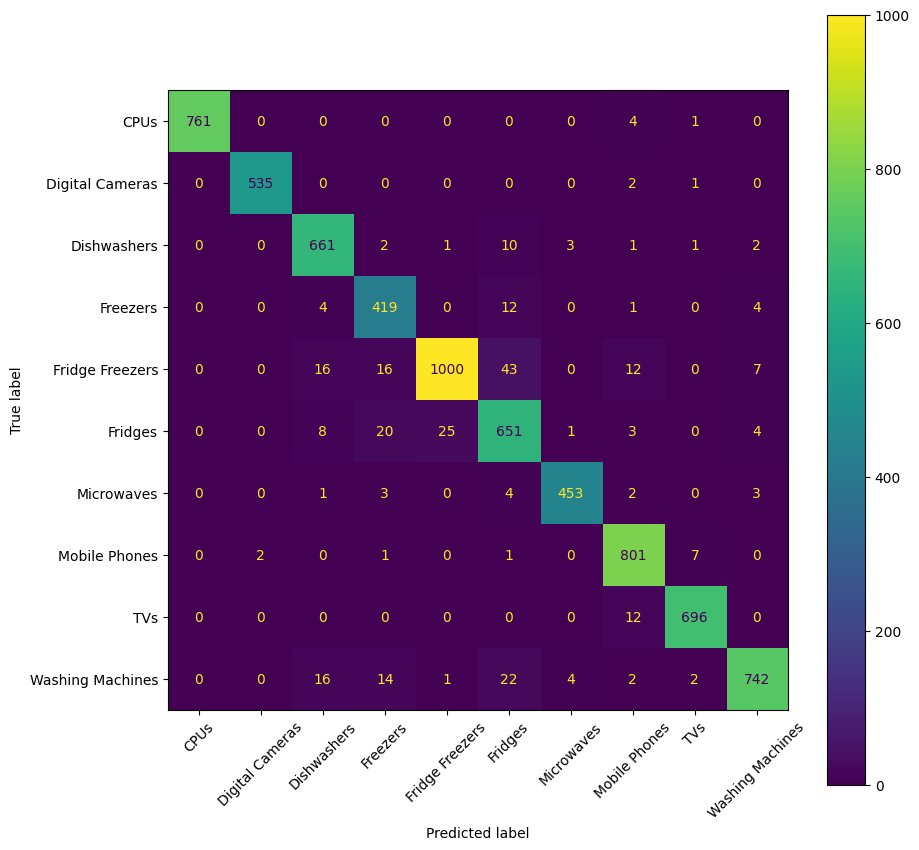

In [28]:
# Confusion matrix arata unde greseste modelul:
# - pe diagonala sunt predictiile corecte
# - in afara diagonalei vedem confuziile dintre categorii (ex: Fridges vs Freezers)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(
    baseline_lr, X_test, y_test,
    xticks_rotation=45,
    ax=ax
)
plt.show()


In [29]:
# Facem un sanity check cu exemplele oferite in task.
# Ideea: verificam daca modelul "se comporta" logic pe cateva titluri cunoscute.
tests = [
    "iphone 7 32gb gold,4,3,Apple iPhone 7 32GB",
    "olympus e m10 mark iii geh use silber",
    "kenwood k20mss15 solo",
    "bosch wap28390gb 8kg 1400 spin",
    "bosch serie 4 kgv39vl31g",
    "smeg sbs8004po"
]

for t in tests:
    print(t, "=>", baseline_lr.predict([t.lower().strip()])[0])


iphone 7 32gb gold,4,3,Apple iPhone 7 32GB => Mobile Phones
olympus e m10 mark iii geh use silber => Digital Cameras
kenwood k20mss15 solo => Microwaves
bosch wap28390gb 8kg 1400 spin => Washing Machines
bosch serie 4 kgv39vl31g => Dishwashers
smeg sbs8004po => Fridges


In [30]:
# Salvam modelul antrenat (pipeline complet: tfidf + classifier) intr-un fisier .pkl.
# Acesta va fi folosit ulterior in scriptul predict_category.py.
import joblib, os

os.makedirs("/content/models", exist_ok=True)
MODEL_PATH = "/content/models/product_category_model.pkl"

joblib.dump(baseline_lr, MODEL_PATH)

MODEL_PATH


'/content/models/product_category_model.pkl'

In [31]:
# Afisam top 3 categorii cu probabilitati pentru un titlu dat.
# Asta e foarte util in productie: chiar daca top1 e gresit,
# userul poate vedea alternativele.
import numpy as np

sample_title = "iphone 7 32gb gold"
proba = baseline_lr.predict_proba([sample_title.lower().strip()])[0]
classes = baseline_lr.classes_

top_idx = np.argsort(proba)[::-1][:3]
[(classes[i], float(proba[i])) for i in top_idx]


[('Mobile Phones', 0.9609695566309266),
 ('Fridges', 0.005087854452424677),
 ('Freezers', 0.0046373651389230025)]